In [49]:
# import the necessary packages
import cv2
import numpy as np
from matplotlib import font_manager, rc, rcParams
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, color, measure
from skimage.restoration import denoise_nl_means
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import pandas as pd
import argparse
import imutils
%matplotlib inline 

rcParams['figure.dpi'] = 900
rc('font',family='Times New Roman',size=10)
rcParams['axes.titlepad'] = 10
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
size=15, weight='normal', stretch='normal')
axis_font = {'fontname':'Times New Roman','fontsize':10}

<ipython-input-50-d8bd400cbf35>:32: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=15,


[INFO] 88 Nanoparticles found in the micrograph


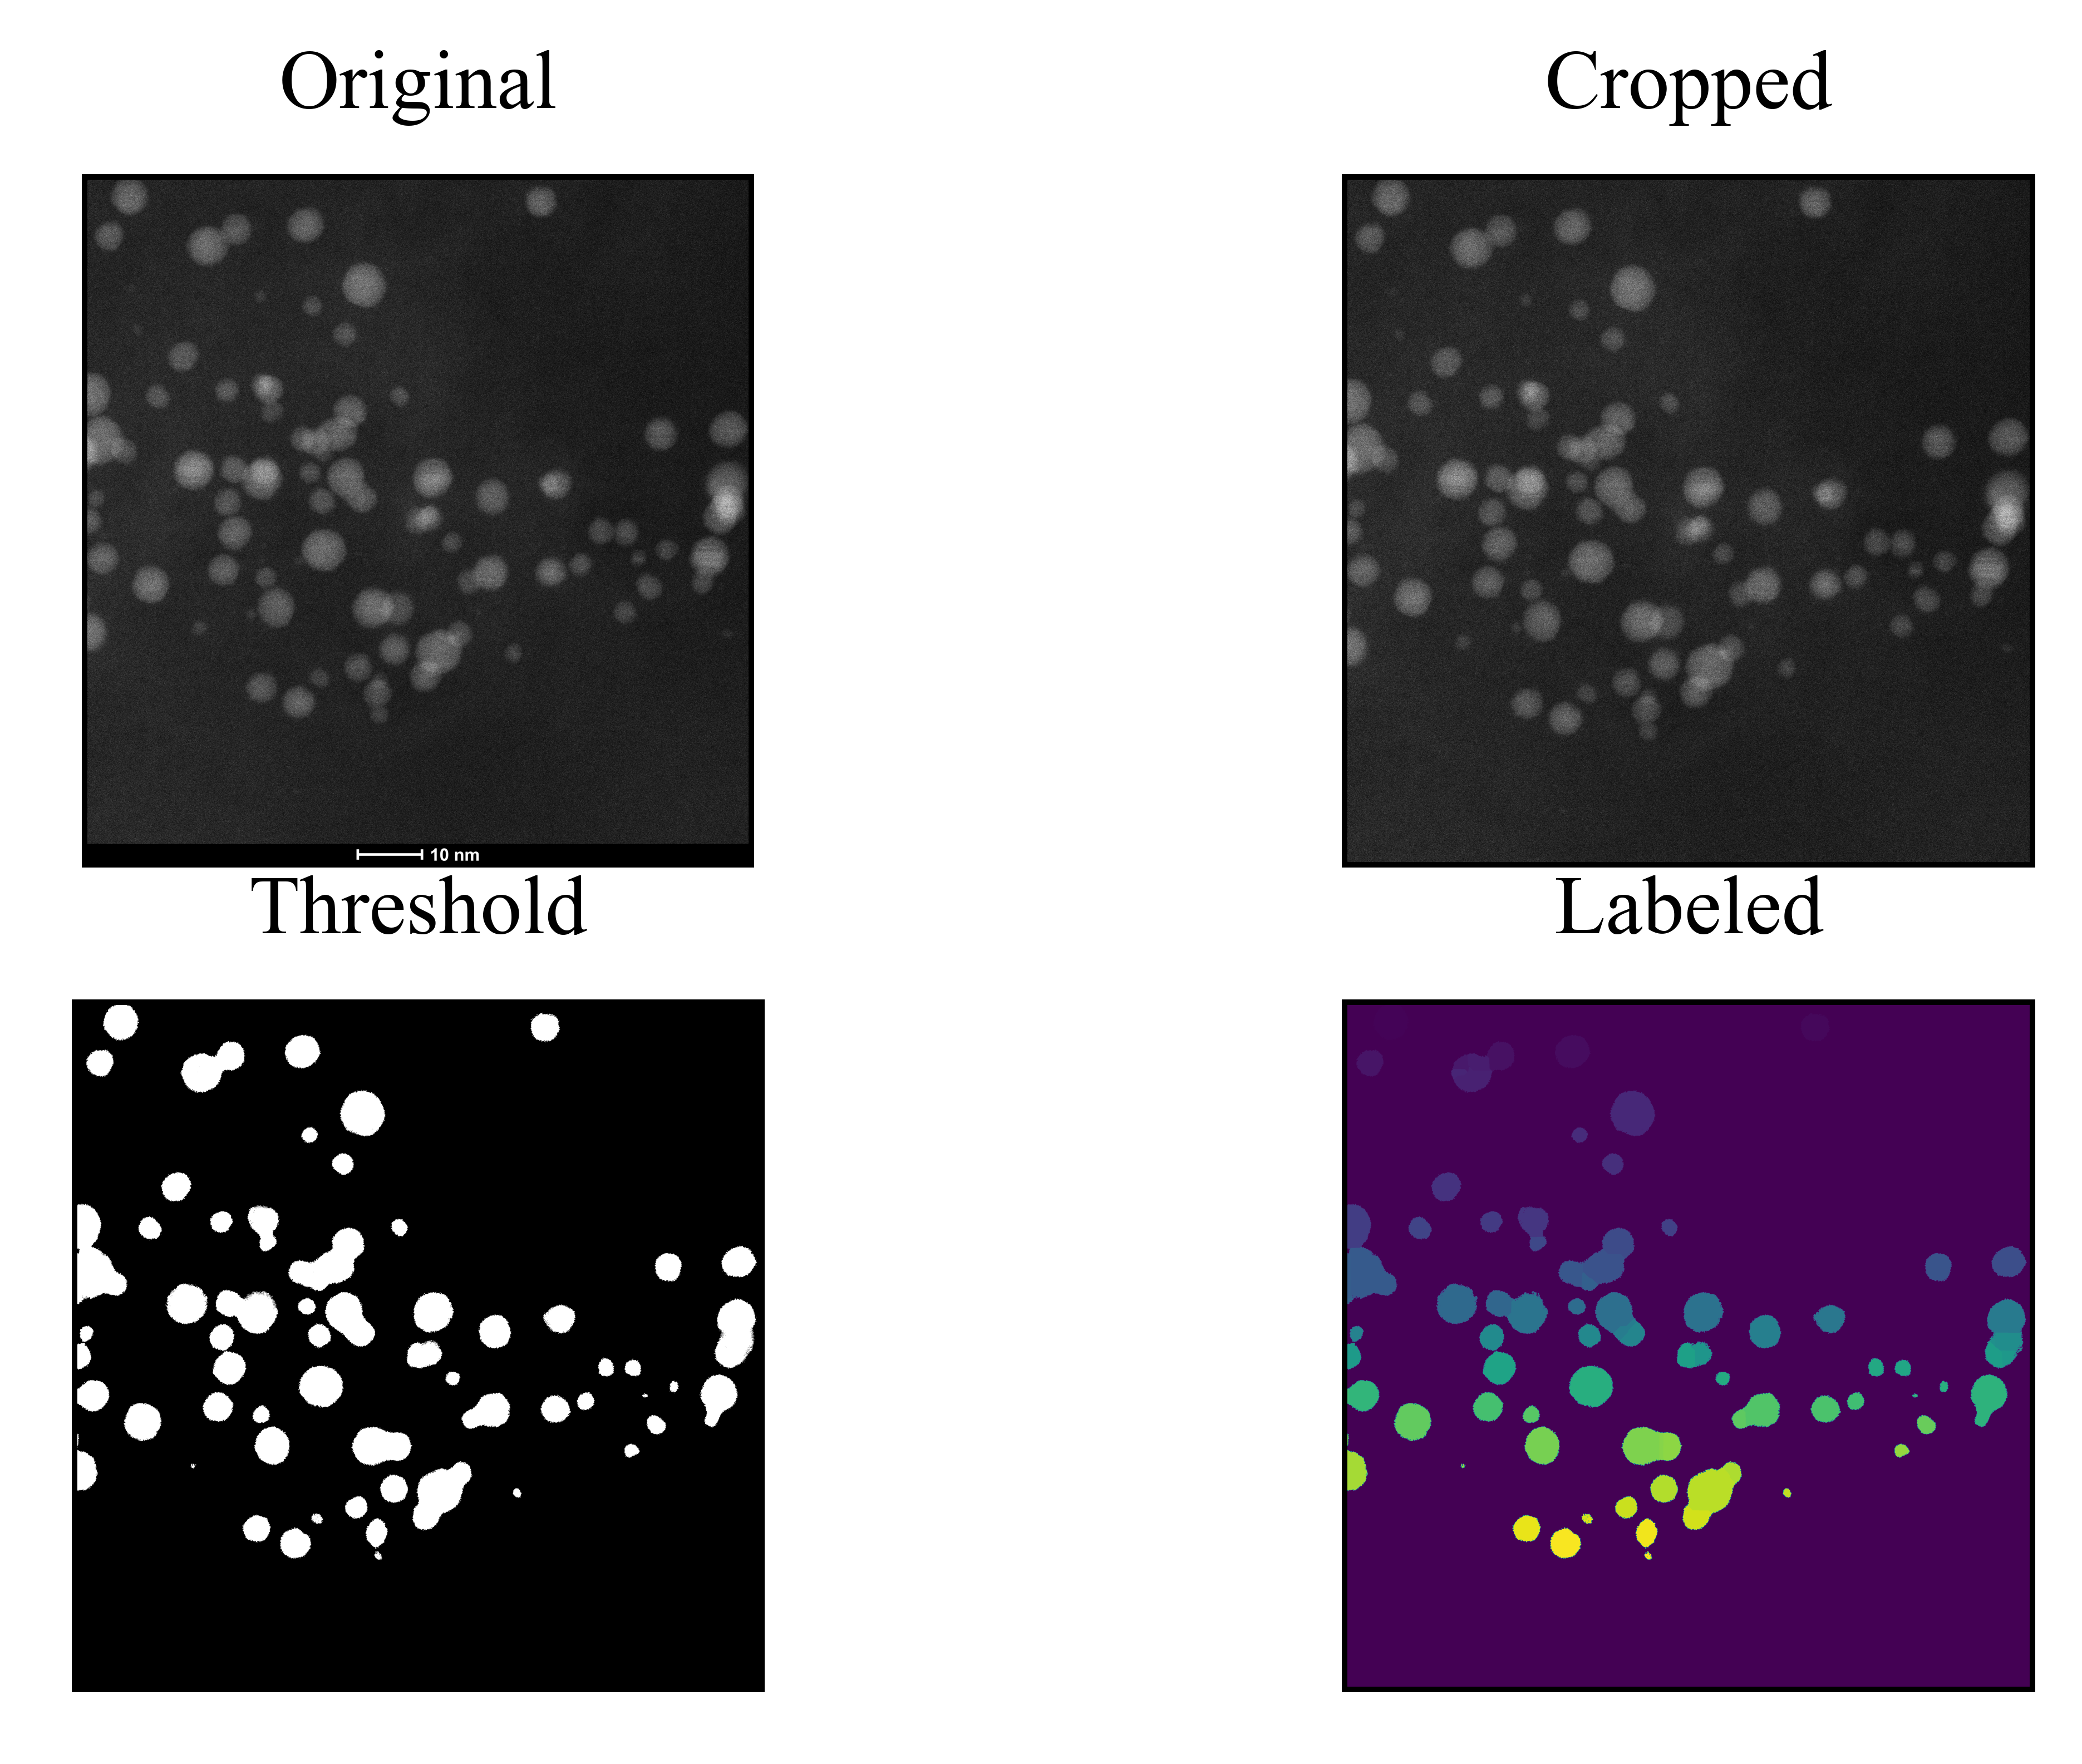

In [50]:
"""
All necessary packages are now imported, let's crop the STEM
image to remove the scale bar. Calibrations are done based on
pixel-to-nm ratio. The image size in terms of pixels are 
4096 x 4226. To make the shape even, lets crop from the bottom
of the y-direction to get a 4096 x 4096 image
"""

x,y = 0, 0
w,h = 4096, 4096

#image = cv2.imread('Documents/Sandia/Nanoparticles/DL070219_near_5um_002.tif')
image = cv2.imread('DL070219_near_5um_007.tif')
crop_image = image[x:x+w, y:y+h]
cv2.imshow("cropped", crop_image)

pixels_to_nm = (103.70/4096) #1 pixel = 2.955nm

shifted = cv2.pyrMeanShiftFiltering(crop_image, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
eroded = cv2.erode(thresh, kernel, iterations=1)
dilated= cv2.dilate(eroded, kernel, iterations=1)

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map

D = ndimage.distance_transform_edt(dilated)
localMax = peak_local_max(D, indices=False, min_distance=15,
    labels=dilated)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then apply the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=dilated)

plt.figure('Original')
plt.subplot(2,2,1)
plt.gca().set_title('Original')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(image, cmap='gray')


plt.subplot(2,2,2)
plt.gca().set_title('Cropped')
plt.xticks([]), plt.yticks([])
plt.imshow(crop_image, cmap='gray')

plt.subplot(2,2,3)
plt.gca().set_title('Threshold')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(thresh, cmap='gray')


plt.subplot(2,2,4)
plt.gca().set_title('Labeled')
plt.xticks([]), plt.yticks([])
plt.imshow(labels)

print("[INFO] {} Nanoparticles found in the micrograph".format(len(np.unique(labels)) - 1))

In [5]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    c = max(cnts, key=cv2.contourArea)
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (255, 0, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
#cv2.imshow("Output", image)
cv2.imwrite('Training/Looped/DL070219_near_5um_007_Segmented_Image.jpg', image)

True

In [88]:
clusters = measure.regionprops(labels, crop_image)

propList = ['Area',
           'eccentricity']
    
output_file = open('Training/CSV_File/DL070219_near_5um_007_Measurements1.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n')

for cluster_props in clusters:
    #Output desired properties into excel
    output_file.write(str(cluster_props['Label']))
    
    for i,prop in enumerate(propList):
        if (prop.find('Area') <20):
            to_print = cluster_props[prop]*pixels_to_nm**2
        elif(prop.find('Area') >4):
            to_print = cluster_props[prop]*pixels_to_nm**2
        elif(prop.find('eccentricity') <1):
            to_print = cluster_props[prop]
        else:
            to_print = cluster_props[prop]
        output_file.write(',' + str(to_print))
    output_file.write('\n')
    
#data = pd.read_csv('Training/CSV_File/DL070219_near_5um_007_Measurements.csv')
#if 10000 <= number <= 30000

count    88.000000
mean     11.871629
std       9.429487
min       0.271130
25%       4.389682
50%       9.240542
75%      16.846771
max      38.898539
Name: Area, dtype: float64


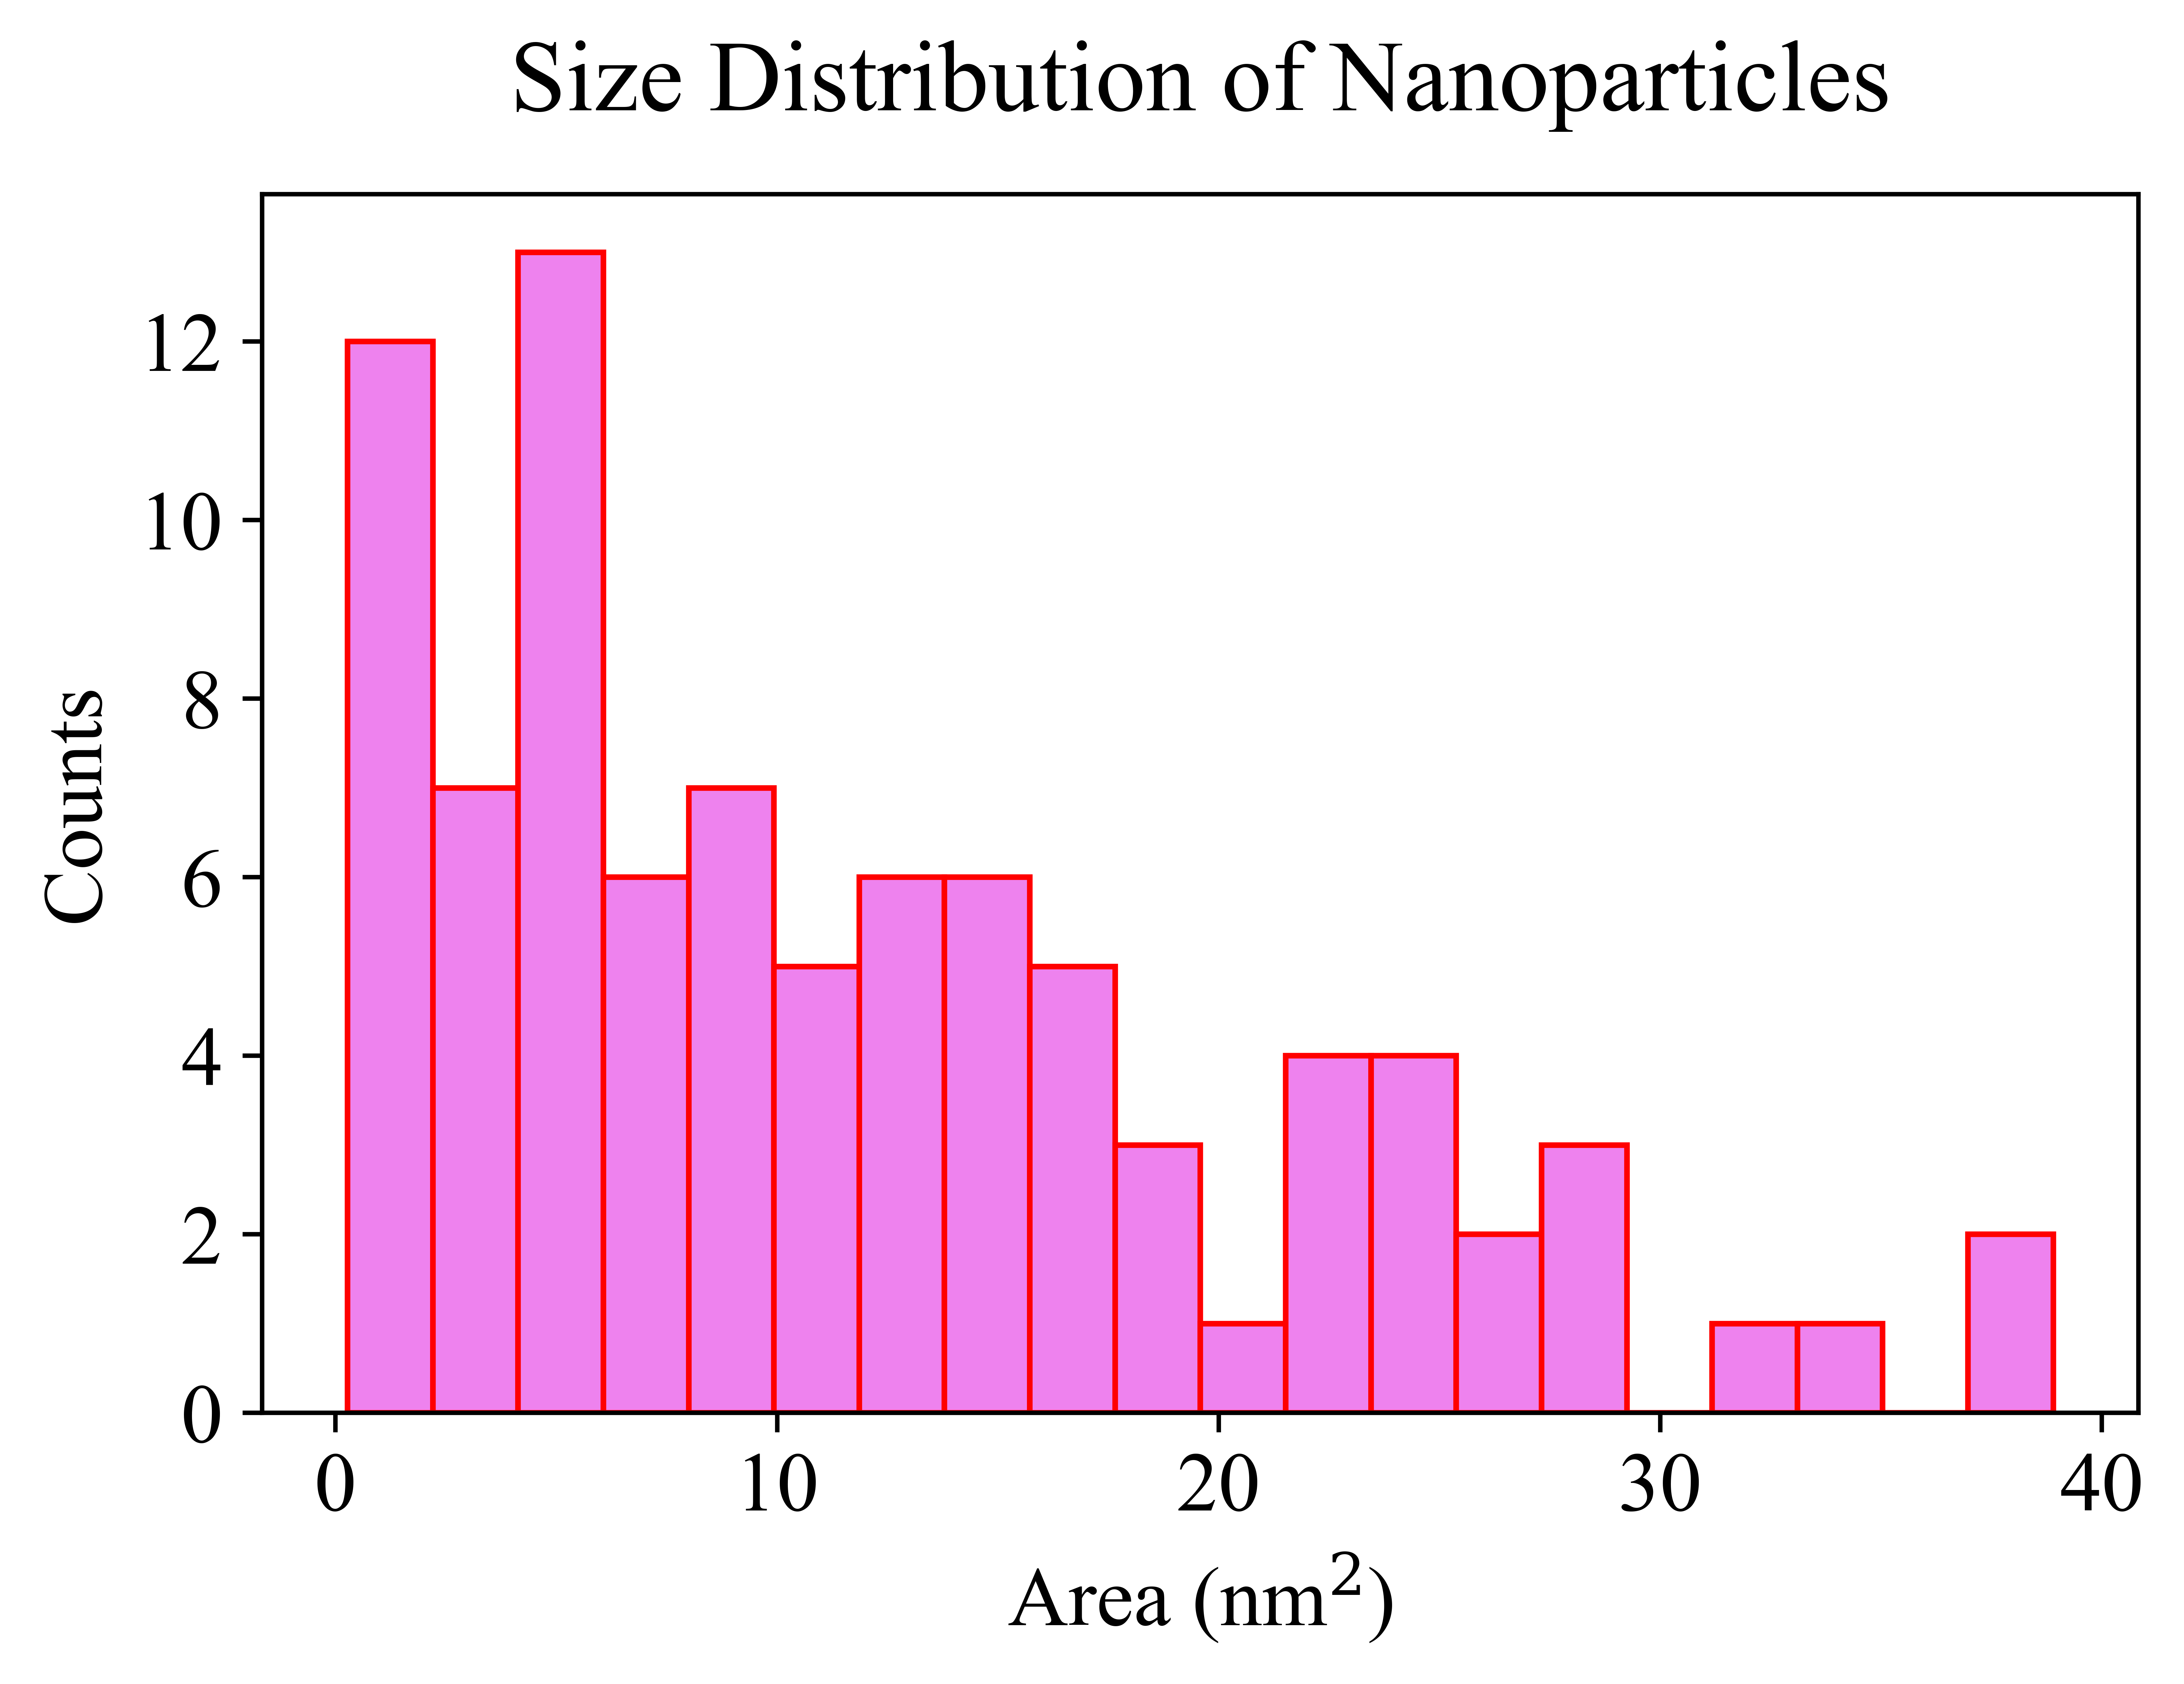

In [48]:
rcParams['figure.dpi'] = 1200
rc('font',family='Times New Roman',size=15)
rcParams['axes.titlepad'] = 15
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
size=15, weight='normal', stretch='normal')
axis_font = {'fontname':'Times New Roman','fontsize':15}

data = pd.read_csv('Training/CSV_File/DL070219_near_5um_007_Measurements1.csv')

x = data.Area
mx = int(data['Area'].max())
mn = int(data['Area'].min())
md = data['Area'].median()
de = data['Area'].describe()


#counts = plt.legend(handles=[mx])

num_bins = 20

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, color='violet', stacked=True, edgecolor='red')

# add a 'best fit' line
#ax.plot(bins, y, '--')
ax.set_xlabel('Area (nm$^2$)')
ax.set_ylabel('Counts')
ax.set_title(r'Size Distribution of Nanoparticles')

#plt.gca().add_artist(mx)

#plt.legend(['%X =' %np.mean(x)])
#legend = ['%s (%.1f a week)' %(col_name, df[col_name].mean()) 
          #for col_name in df.columns]
#plt.legend(['Min = 78.6', 'Max = 4855', 'Std = 540', 'Mean = 542'])
plt.savefig('Training/Area/DL070219_near_5um_007_SizeDistribution.jpg')
#print(mx)
#print('Median', md)
print(de)

count    88.000000
mean      0.000345
std       0.000141
min       0.000042
25%       0.000236
50%       0.000322
75%       0.000457
max       0.000636
Name: eccentricity, dtype: float64


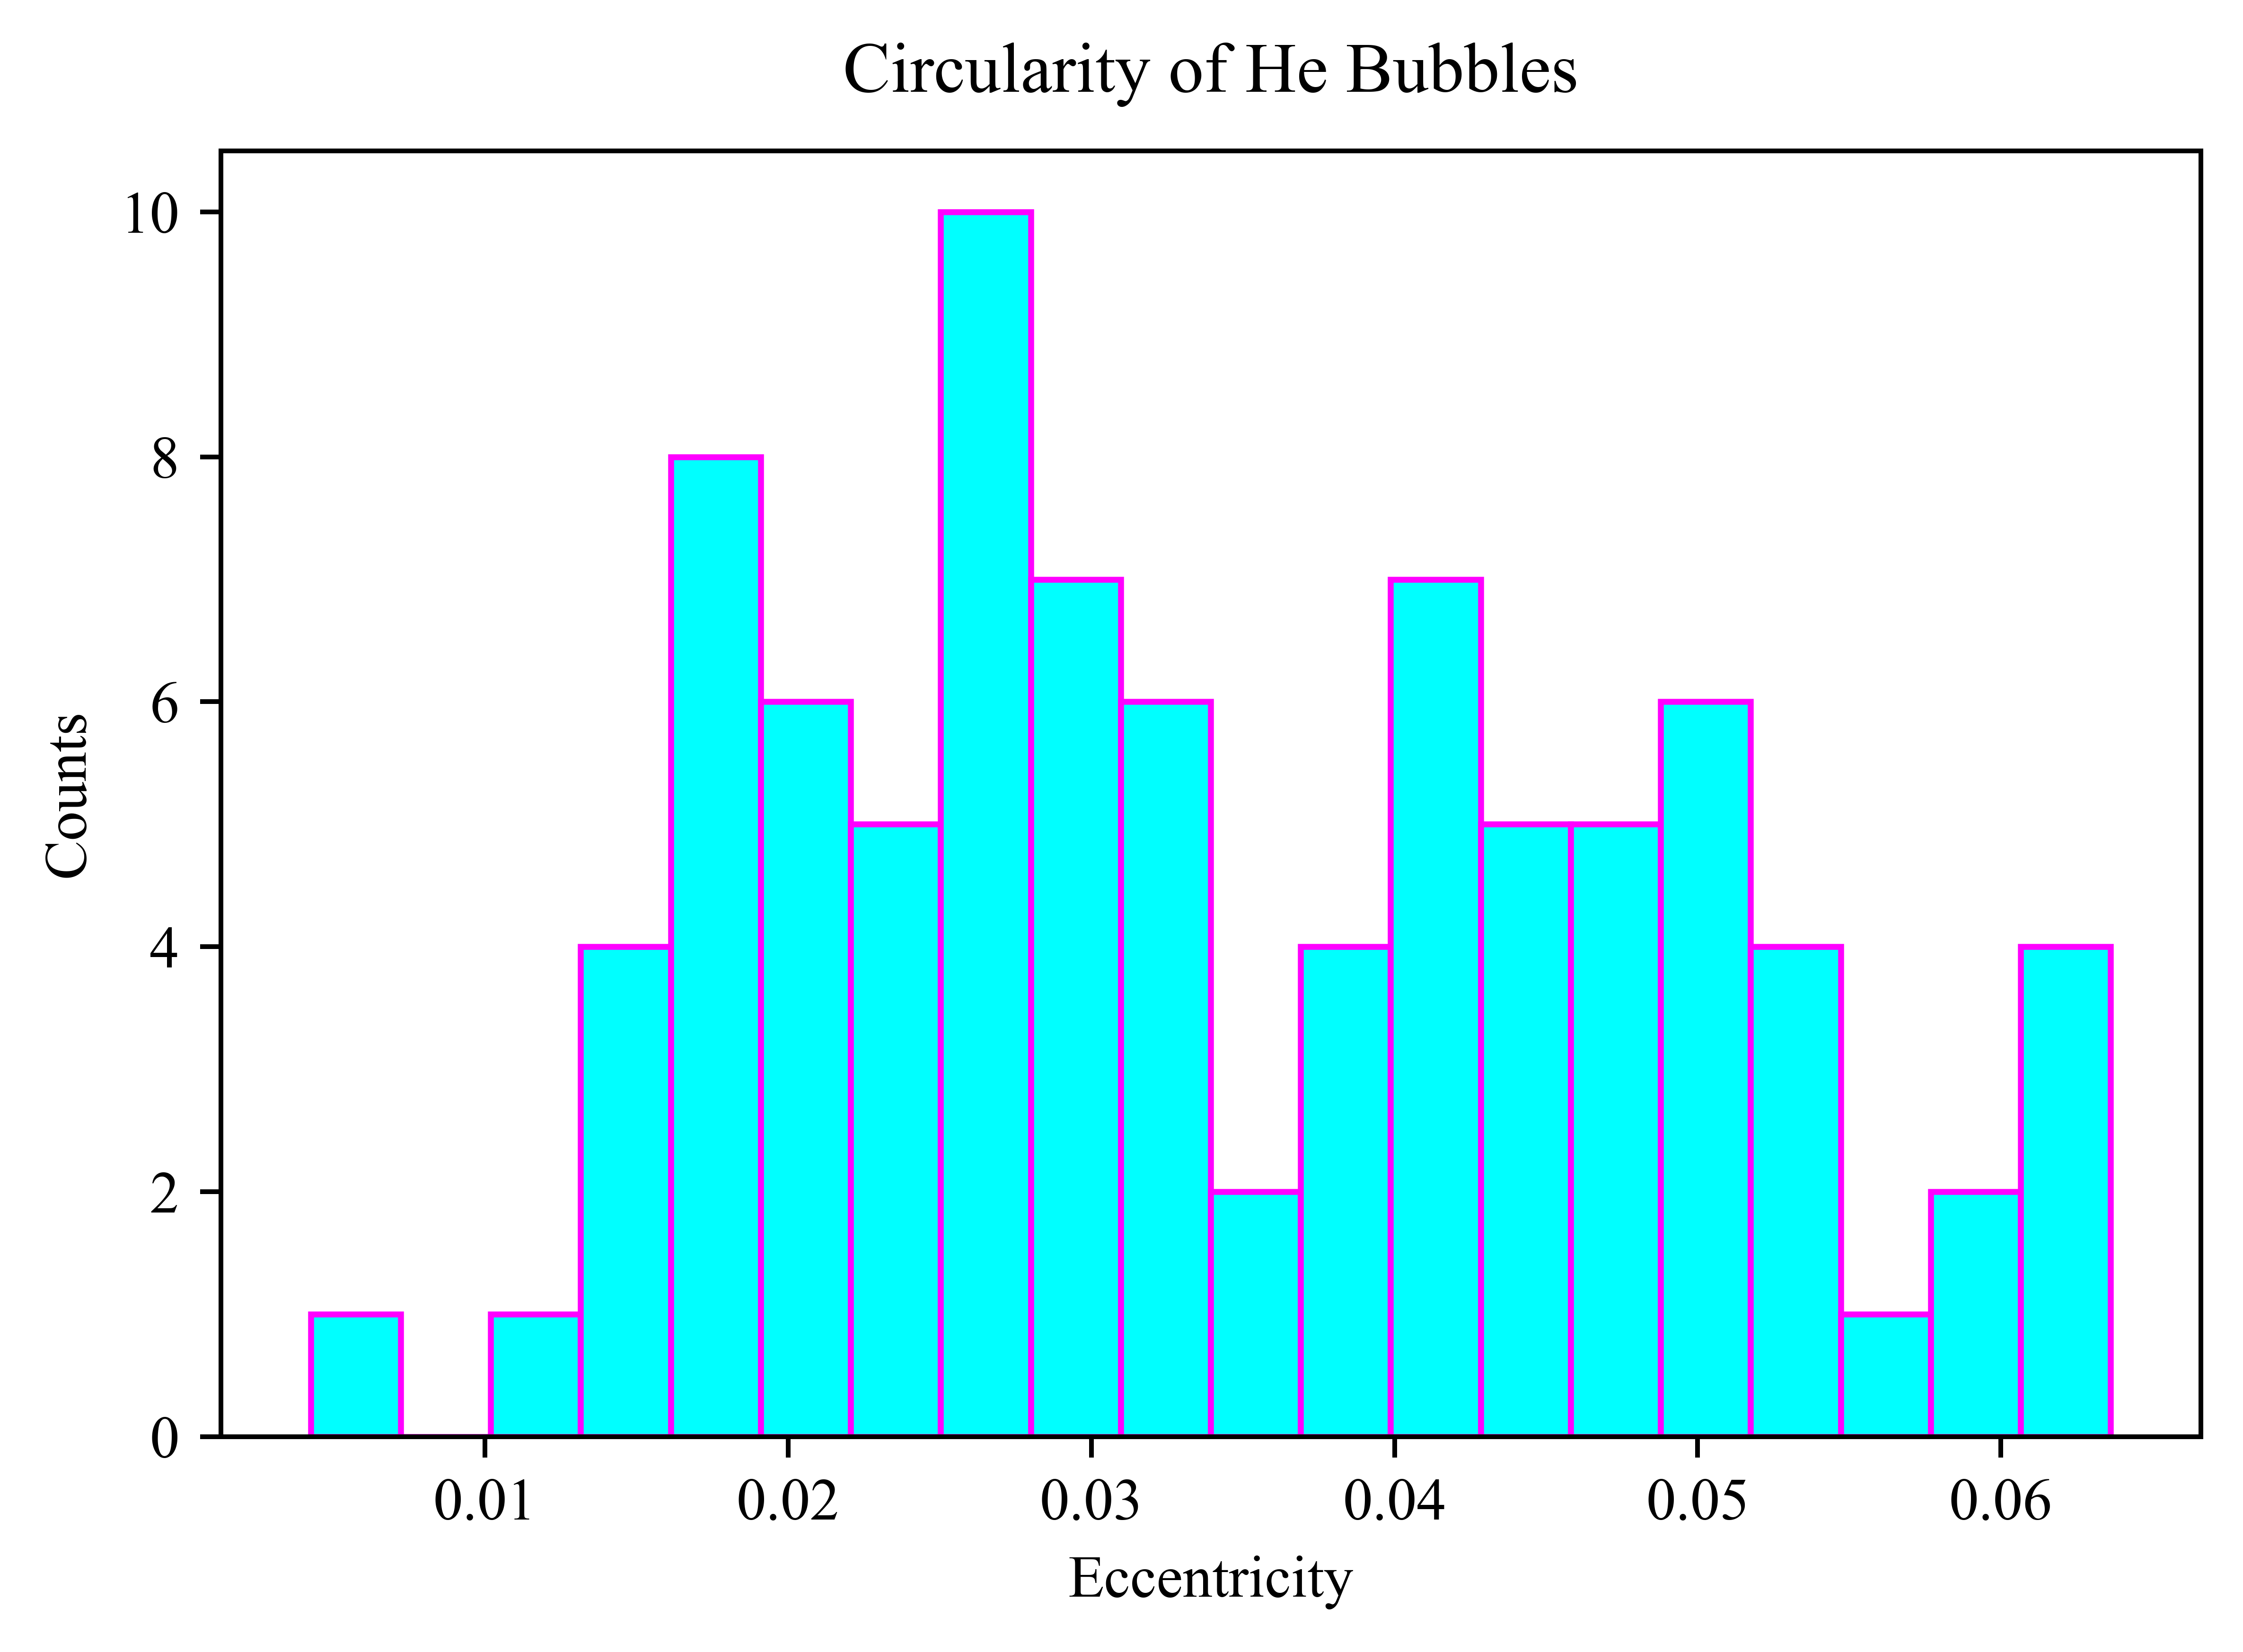

In [86]:
x = data.eccentricity *100

de = data['eccentricity'].describe()

num_bins = 20

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, color='cyan', stacked=True, edgecolor='magenta')

ax.set_xlabel('Eccentricity')
ax.set_ylabel('Counts')
ax.set_title(r'Circularity of He Bubbles')

plt.savefig('Training/Eccentricity/DL070219_near_5um_007_ShapeDistribution.jpg')
print(de)

count    88.000000
mean     11.871629
std       9.429487
min       0.271130
25%       4.389682
50%       9.240542
75%      16.846771
max      38.898539
Name: Area, dtype: float64


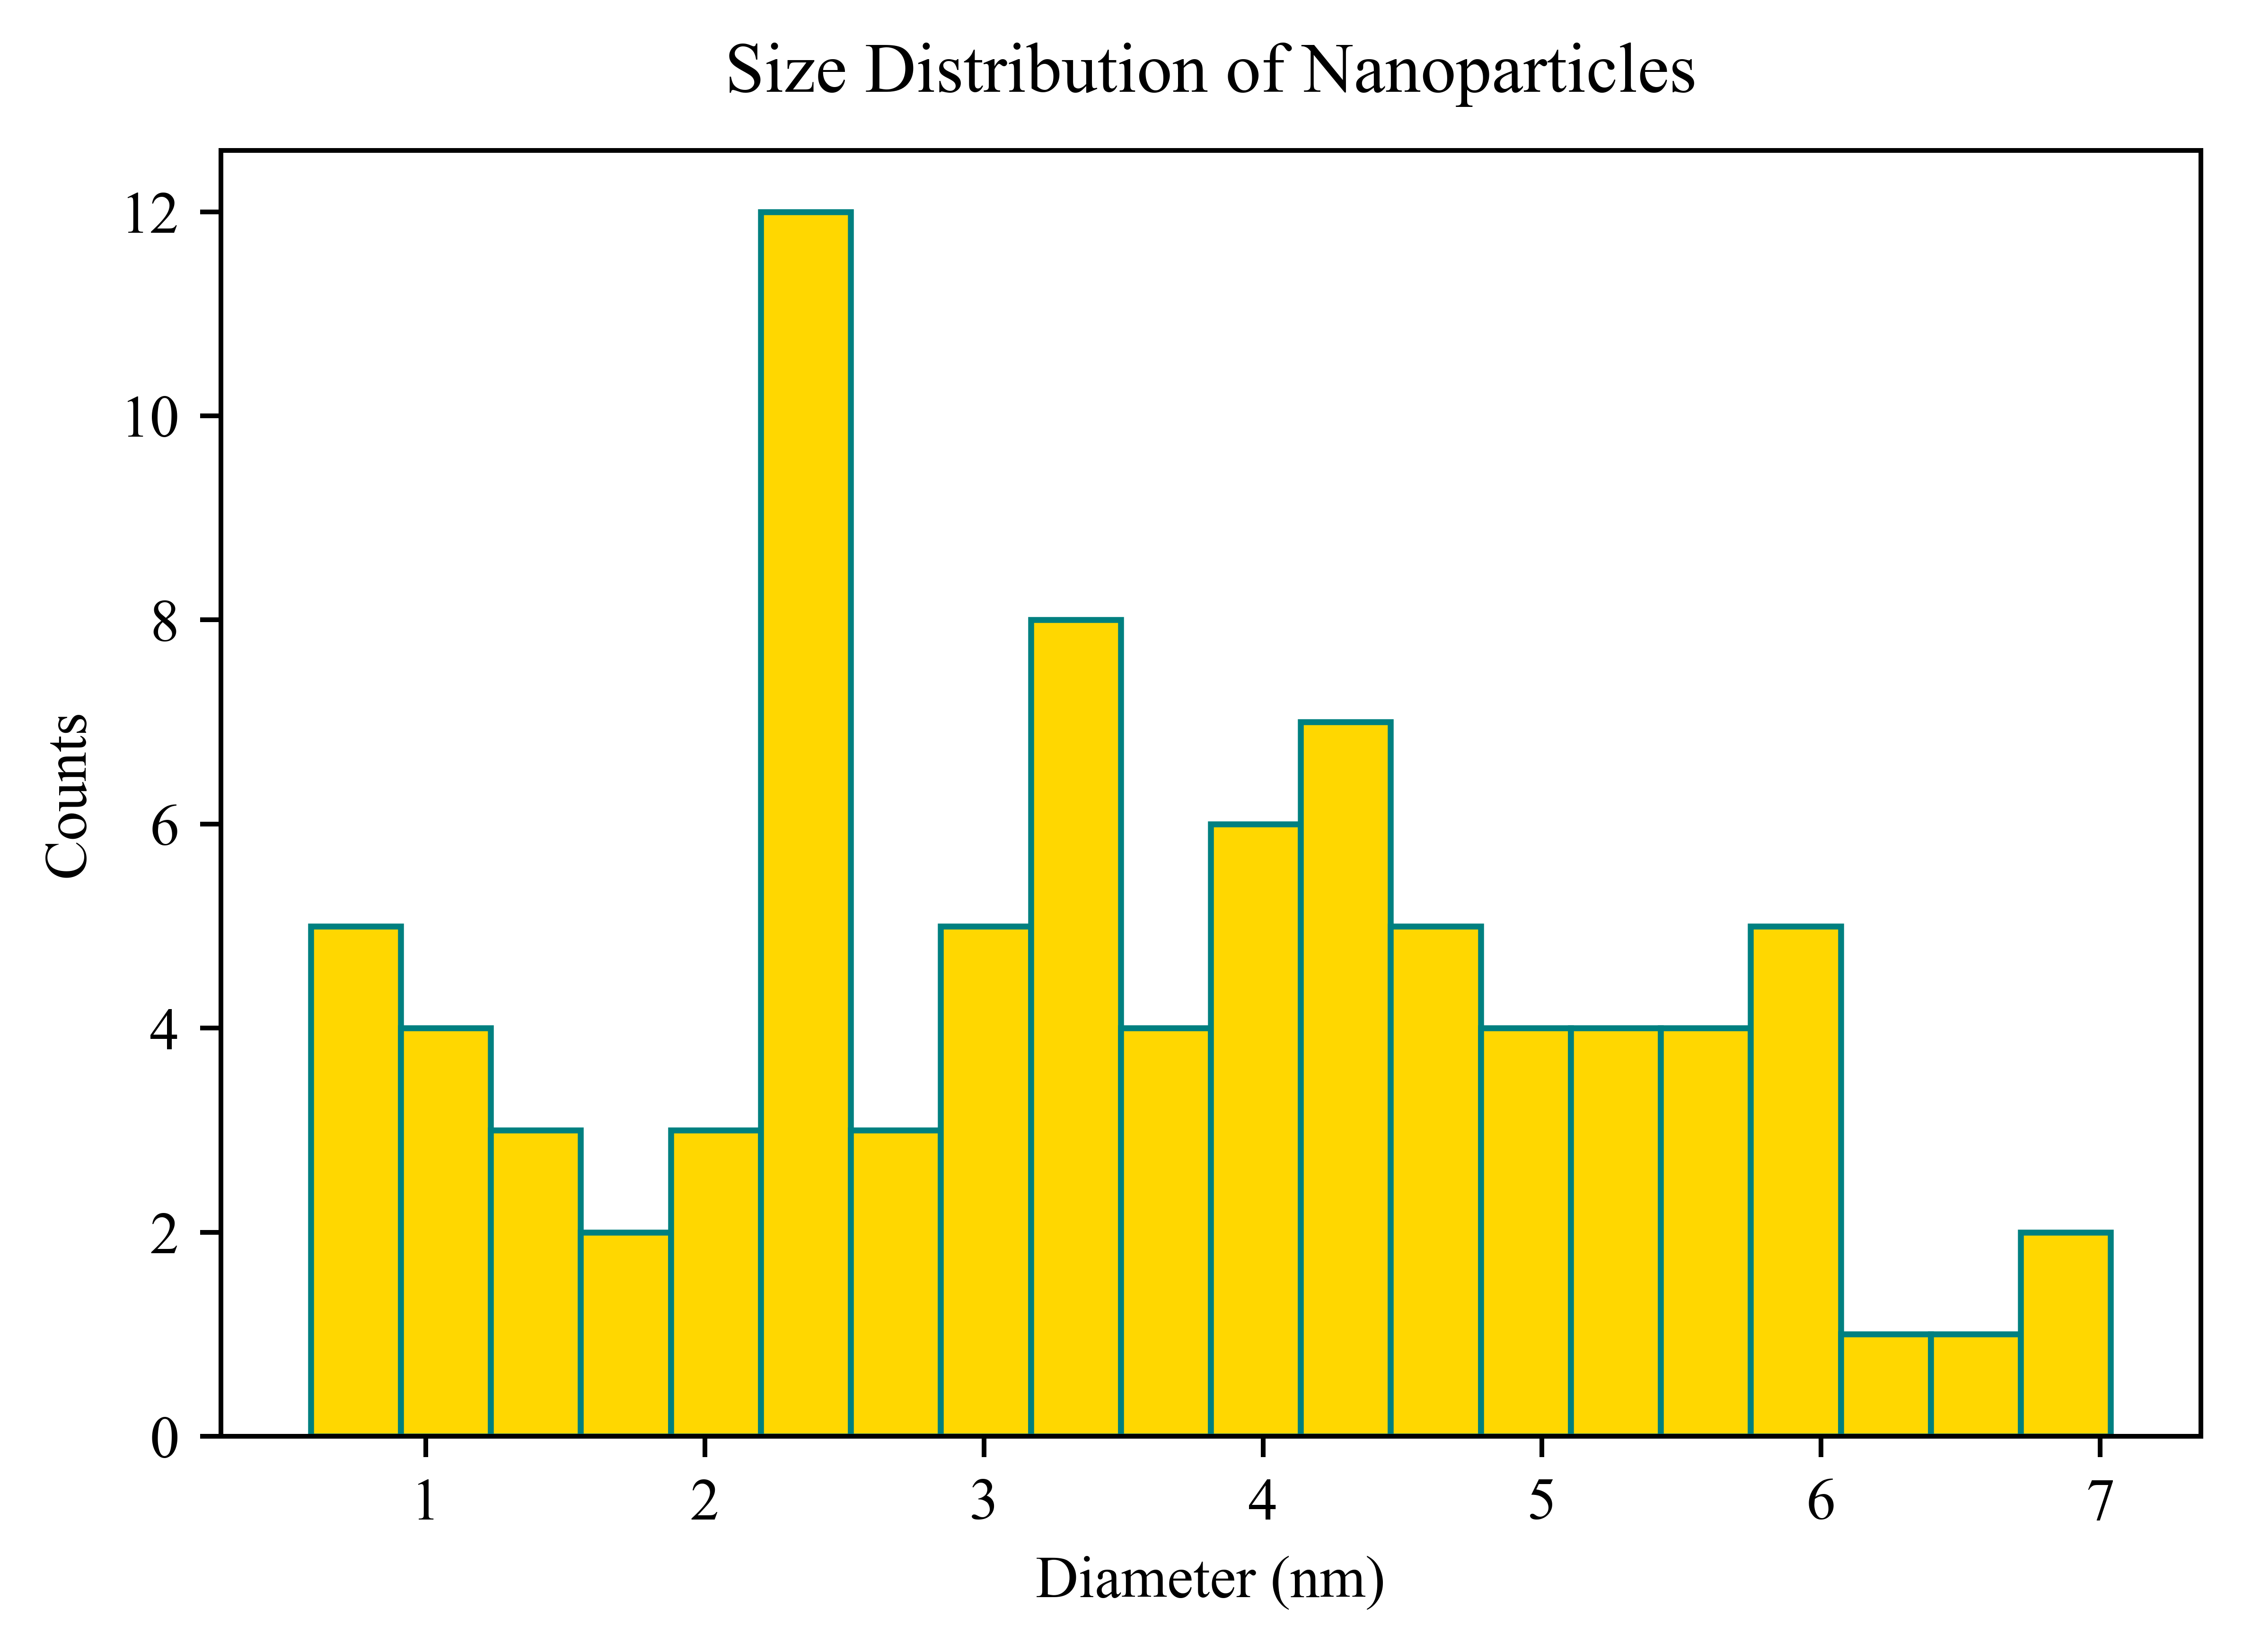

In [90]:
from math import sqrt, pi

x = (data.Area / pi) * 4
x = x**(0.5)
mx = int(data['Area'].max())
mn = int(data['Area'].min())
md = data['Area'].median()
de = data['Area'].describe()


#counts = plt.legend(handles=[mx])

num_bins = 20

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, color='gold', stacked=True, edgecolor='teal')

# add a 'best fit' line
#ax.plot(bins, y, '--')
ax.set_xlabel('Diameter (nm)')
ax.set_ylabel('Counts')
ax.set_title(r'Size Distribution of Nanoparticles')

plt.savefig('Training/Diameter/SizeDistribution.jpg')
print(de)